In [1]:
import os
import numpy as np

import torch.onnx
import onnx
import warnings
from onnx_tf.backend import prepare

import tensorflow as tf
from tensorflow.python.tools.import_pb_to_tensorboard import import_to_tensorboard
from tensorflow.python.platform import gfile
from tensorflow.contrib.lite.python.lite import TFLiteConverter

import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image

/Users/samuelcahyawijaya/htdocs/python/onnx-tensorflow/onnx_tf/common/__init__.py:87: UserWarning: FrontendHandler.get_outputs_names is deprecated. It will be removed in future release.. Use node.outputs instead.
  warnings.warn(message)


In [2]:
label_dict = {
    0: 'NINE',
    1: 'ZERO',
    2: 'SEVEN',
    3: 'SIX',
    4: 'ONE',
    5: 'EIGHT',
    6: 'FOUR',
    7: 'THREE',
    8: 'TWO',
    9: 'FIVE', 
}

In [3]:
os.environ["ONNX_ML"] = "1"
warnings.filterwarnings('ignore') # Ignore all the warning messages in this tutorial

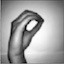

In [4]:
img = Image.open('test.jpg').convert('L')
display(img) # show the image

### Export from PyTorch

In [5]:
# define the CNN architecture without Dropout layer
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1_1 = nn.Conv2d(1, 8, 3, padding=1)      
        self.conv1_2 = nn.Conv2d(8, 16, 3, padding=1)      
        self.conv1_3 = nn.Conv2d(16, 32, 3, padding=1)
        
        self.pool1 = nn.MaxPool2d(2) 
        
        self.conv2_1 = nn.Conv2d(32, 40, 3, padding=1)      
        self.conv2_2 = nn.Conv2d(40, 48, 3, padding=1)      
        self.conv2_3 = nn.Conv2d(48, 64, 3, padding=1)

        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3_1 = nn.Conv2d(64, 72, 3, padding=1)      
        self.conv3_2 = nn.Conv2d(72, 80, 3, padding=1)      
        self.conv3_3 = nn.Conv2d(80, 96, 3, padding=1)
        
        self.pool3 = nn.MaxPool2d(2)
        
        self.conv4_1 = nn.Conv2d(96, 128, 3, padding=1)      
        self.conv4_2 = nn.Conv2d(128, 192, 3, padding=1)
        self.conv4_3 = nn.Conv2d(192, 256, 3, padding=1)
        
        self.fc1 = nn.Linear(256, 1024)
        self.fc2 = nn.Linear(1024, 10)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        # 64x64x1 => 32x32x8
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.relu(self.conv1_3(x))
        x = F.relu(self.pool1(x))
        
        # 32x32x8 => 16x16x16
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = F.relu(self.conv2_3(x))
        x = F.relu(self.pool2(x))
        
        # 16x16x16 => 8x8x32
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = F.relu(self.pool3(x))
        
        # 8x8x32 => 8x8x256
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))

        # Reduce Mean & Linear
        x = torch.mean(torch.mean(x, dim=-1), dim=-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [6]:
# Load model
model = Net()
model.load_state_dict(torch.load('./model_sl_3968.pt', map_location=lambda storage, location: storage))
model.eval()

Net(
  (conv1_1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(32, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(40, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_3): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(64, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(72, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(80, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv2d(96, 128, 

In [7]:
# Test predict
x = torch.from_numpy(np.expand_dims(np.expand_dims(np.asarray(img, dtype=np.float32), axis=0), axis=0))
y = model(x)

y_idx = torch.argmax(y)
y, label_dict[int(y_idx)]

(tensor([[ -3.2384,  32.9433,  -6.1564, -18.4737,  -2.4728,   0.2746,  -1.5060,
          -14.4440, -26.7159,  -7.6219]], grad_fn=<ThAddmmBackward>), 'ZERO')

In [8]:
# Prepare dummy tensor for defining input size
dummy_input = torch.randn(1, 1, 64, 64)

# Invoke export
torch.onnx.export(model, dummy_input, "sign_lang_net.onnx")

### Import to Tensorflow

In [9]:
model = onnx.load('sign_lang_net.onnx') # Load the ONNX file
tf_rep = prepare(model) # Import the ONNX model to Tensorflow

In [10]:
print(tf_rep.inputs) # Input nodes to the model
print('-----')
print(tf_rep.outputs) # Output nodes from the model
print('-----')
print(tf_rep.tensor_dict) # All nodes in the model

['0']
-----
['63']
-----
{'1': <tf.Tensor 'Const:0' shape=(8, 1, 3, 3) dtype=float32>, '2': <tf.Tensor 'Const_1:0' shape=(8,) dtype=float32>, '3': <tf.Tensor 'Const_2:0' shape=(16, 8, 3, 3) dtype=float32>, '4': <tf.Tensor 'Const_3:0' shape=(16,) dtype=float32>, '5': <tf.Tensor 'Const_4:0' shape=(32, 16, 3, 3) dtype=float32>, '6': <tf.Tensor 'Const_5:0' shape=(32,) dtype=float32>, '7': <tf.Tensor 'Const_6:0' shape=(40, 32, 3, 3) dtype=float32>, '8': <tf.Tensor 'Const_7:0' shape=(40,) dtype=float32>, '9': <tf.Tensor 'Const_8:0' shape=(48, 40, 3, 3) dtype=float32>, '10': <tf.Tensor 'Const_9:0' shape=(48,) dtype=float32>, '11': <tf.Tensor 'Const_10:0' shape=(64, 48, 3, 3) dtype=float32>, '12': <tf.Tensor 'Const_11:0' shape=(64,) dtype=float32>, '13': <tf.Tensor 'Const_12:0' shape=(72, 64, 3, 3) dtype=float32>, '14': <tf.Tensor 'Const_13:0' shape=(72,) dtype=float32>, '15': <tf.Tensor 'Const_14:0' shape=(80, 72, 3, 3) dtype=float32>, '16': <tf.Tensor 'Const_15:0' shape=(80,) dtype=float32>,

In [11]:
tf_rep.run(np.random.randn(1,1,64,64))

Outputs(_0=array([[-0.02238697, -0.29960835, -0.03953697,  0.13984193, -0.0435295 ,
         0.07639679, -0.10470795, -0.18059273, -0.0128672 , -0.29820734]],
      dtype=float32))

In [12]:
x = np.expand_dims(np.expand_dims(np.asarray(img, dtype=np.float32), axis=0), axis=0)
y = tf_rep.run(x)

y, label_dict[np.argmax(y)]

(Outputs(_0=array([[ -3.238375  ,  32.94328   ,  -6.1563983 , -18.473707  ,
          -2.4727979 ,   0.27463698,  -1.5059704 , -14.4439945 ,
         -26.715906  ,  -7.621884  ]], dtype=float32)), 'ZERO')

In [13]:
tf_rep.export_graph("sign_lang_net.pb")
import_to_tensorboard("sign_lang_net.pb", "sl_log")

Instructions for updating:
Use tf.gfile.GFile.
Model Imported. Visualize by running: tensorboard --logdir=sl_log


### Load Tensorflow Graph

In [14]:
tf.reset_default_graph()

In [15]:
in_tensor = 'import/0:0'
out_tensor = 'import/add_13:0'

In [16]:
with gfile.FastGFile("sign_lang_net.pb", 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    with tf.Session() as sess:
        sess.graph.as_default()
        tf.import_graph_def(graph_def)
        tf.global_variables_initializer().run()
        sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
        
        feed_dict = dict([(in_tensor, x)])
        y = sess.run(out_tensor, feed_dict=feed_dict)
        
        print(y, label_dict[np.argmax(y)])

[[ -3.238375    32.94328     -6.1563983  -18.473707    -2.4727979
    0.27463698  -1.5059704  -14.4439945  -26.715906    -7.621884  ]] ZERO


# Move to Tensoflow Lite Model

In [17]:
in_tensor = '0'
out_tensor = 'add_13'

In [18]:
graph_def_file = "sign_lang_net.pb"
input_arrays = [in_tensor]
output_arrays = [out_tensor]

converter = TFLiteConverter.from_frozen_graph(graph_def_file, input_arrays, output_arrays)
tflite_model = converter.convert()

open("sign_lang_net.tflite", "wb").write(tflite_model)

5117180